https://github.com/aws/aws-iot-device-sdk-python

Understand how to use AWS MQTT broker

Useful guide -> https://iotbytes.wordpress.com/mqtt-with-aws-iot-using-python-and-paho/

Download the [AWS IoT root CA](https://www.symantec.com/content/en/us/enterprise/verisign/roots/VeriSign-Class%203-Public-Primary-Certification-Authority-G5.pem) and save to `root-CA.crt`

In [1]:
ls certificates

6556c4125c-certificate.pem.crt  6556c4125c-public.pem.key
6556c4125c-private.pem.key      root-CA.crt


In [2]:
import os
import json

In [3]:
CWD = os.getcwd()

In [4]:
CERTIFICATE_DIR = "certificates"
CA_ROOT_CERT_FILE = f"{CWD}/{CERTIFICATE_DIR}/root-CA.crt"
THING_PRIVATE_KEY = f"{CWD}/{CERTIFICATE_DIR}/6556c4125c-private.pem.key"
THING_CERT_FILE = f"{CWD}/{CERTIFICATE_DIR}/6556c4125c-certificate.pem.crt"

MQTT_HOST = "123-ats.iot.eu-west-1.amazonaws.com" # Get from settings in IOT console
THING_NAME = "robins-lidar"

CLIENT_ID = "robins_mac" # can be an empty string

In [5]:
CA_ROOT_CERT_FILE

'/Users/robincole/sensor-mqtt-aws/certificates/root-CA.crt'

In [6]:
# !pip3 install AWSIoTPythonSDK

OpenSSL version 1.0.1+ is required

In [7]:
import ssl

In [8]:
ssl.OPENSSL_VERSION

'OpenSSL 1.0.2o  27 Mar 2018'

## AWSIoTMQTTClient
This is the client class used for plain MQTT communication with AWS IoT
https://github.com/aws/aws-iot-device-sdk-python#awsiotmqttclient

In [9]:
# Import SDK packages
from AWSIoTPythonSDK.MQTTLib import AWSIoTMQTTClient

In [10]:
# For certificate based connection
myMQTTClient = AWSIoTMQTTClient(CLIENT_ID)

In [11]:
# For TLS mutual authentication
myMQTTClient.configureEndpoint(MQTT_HOST, 8883)

In [12]:
# myMQTTClient.configureCredentials("YOUR/ROOT/CA/PATH", "PRIVATE/KEY/PATH", "CERTIFICATE/PATH")
myMQTTClient.configureCredentials(CA_ROOT_CERT_FILE, THING_PRIVATE_KEY, THING_CERT_FILE)

In [13]:
myMQTTClient.configureOfflinePublishQueueing(-1)  # Infinite offline Publish queueing
myMQTTClient.configureDrainingFrequency(2)  # Draining: 2 Hz
myMQTTClient.configureConnectDisconnectTimeout(10)  # 10 sec
myMQTTClient.configureMQTTOperationTimeout(5)  # 5 sec

In [14]:
myMQTTClient.connect()

True

In [15]:
MQTT_TOPIC = "my_mac"
MQTT_MSG = json.dumps({"message": "Hello from  Mac"})

myMQTTClient.publish(MQTT_TOPIC, MQTT_MSG, 0)

True

I can then see the message on the AWS test page

In [16]:
ls resources

lidar.png      test_page.png


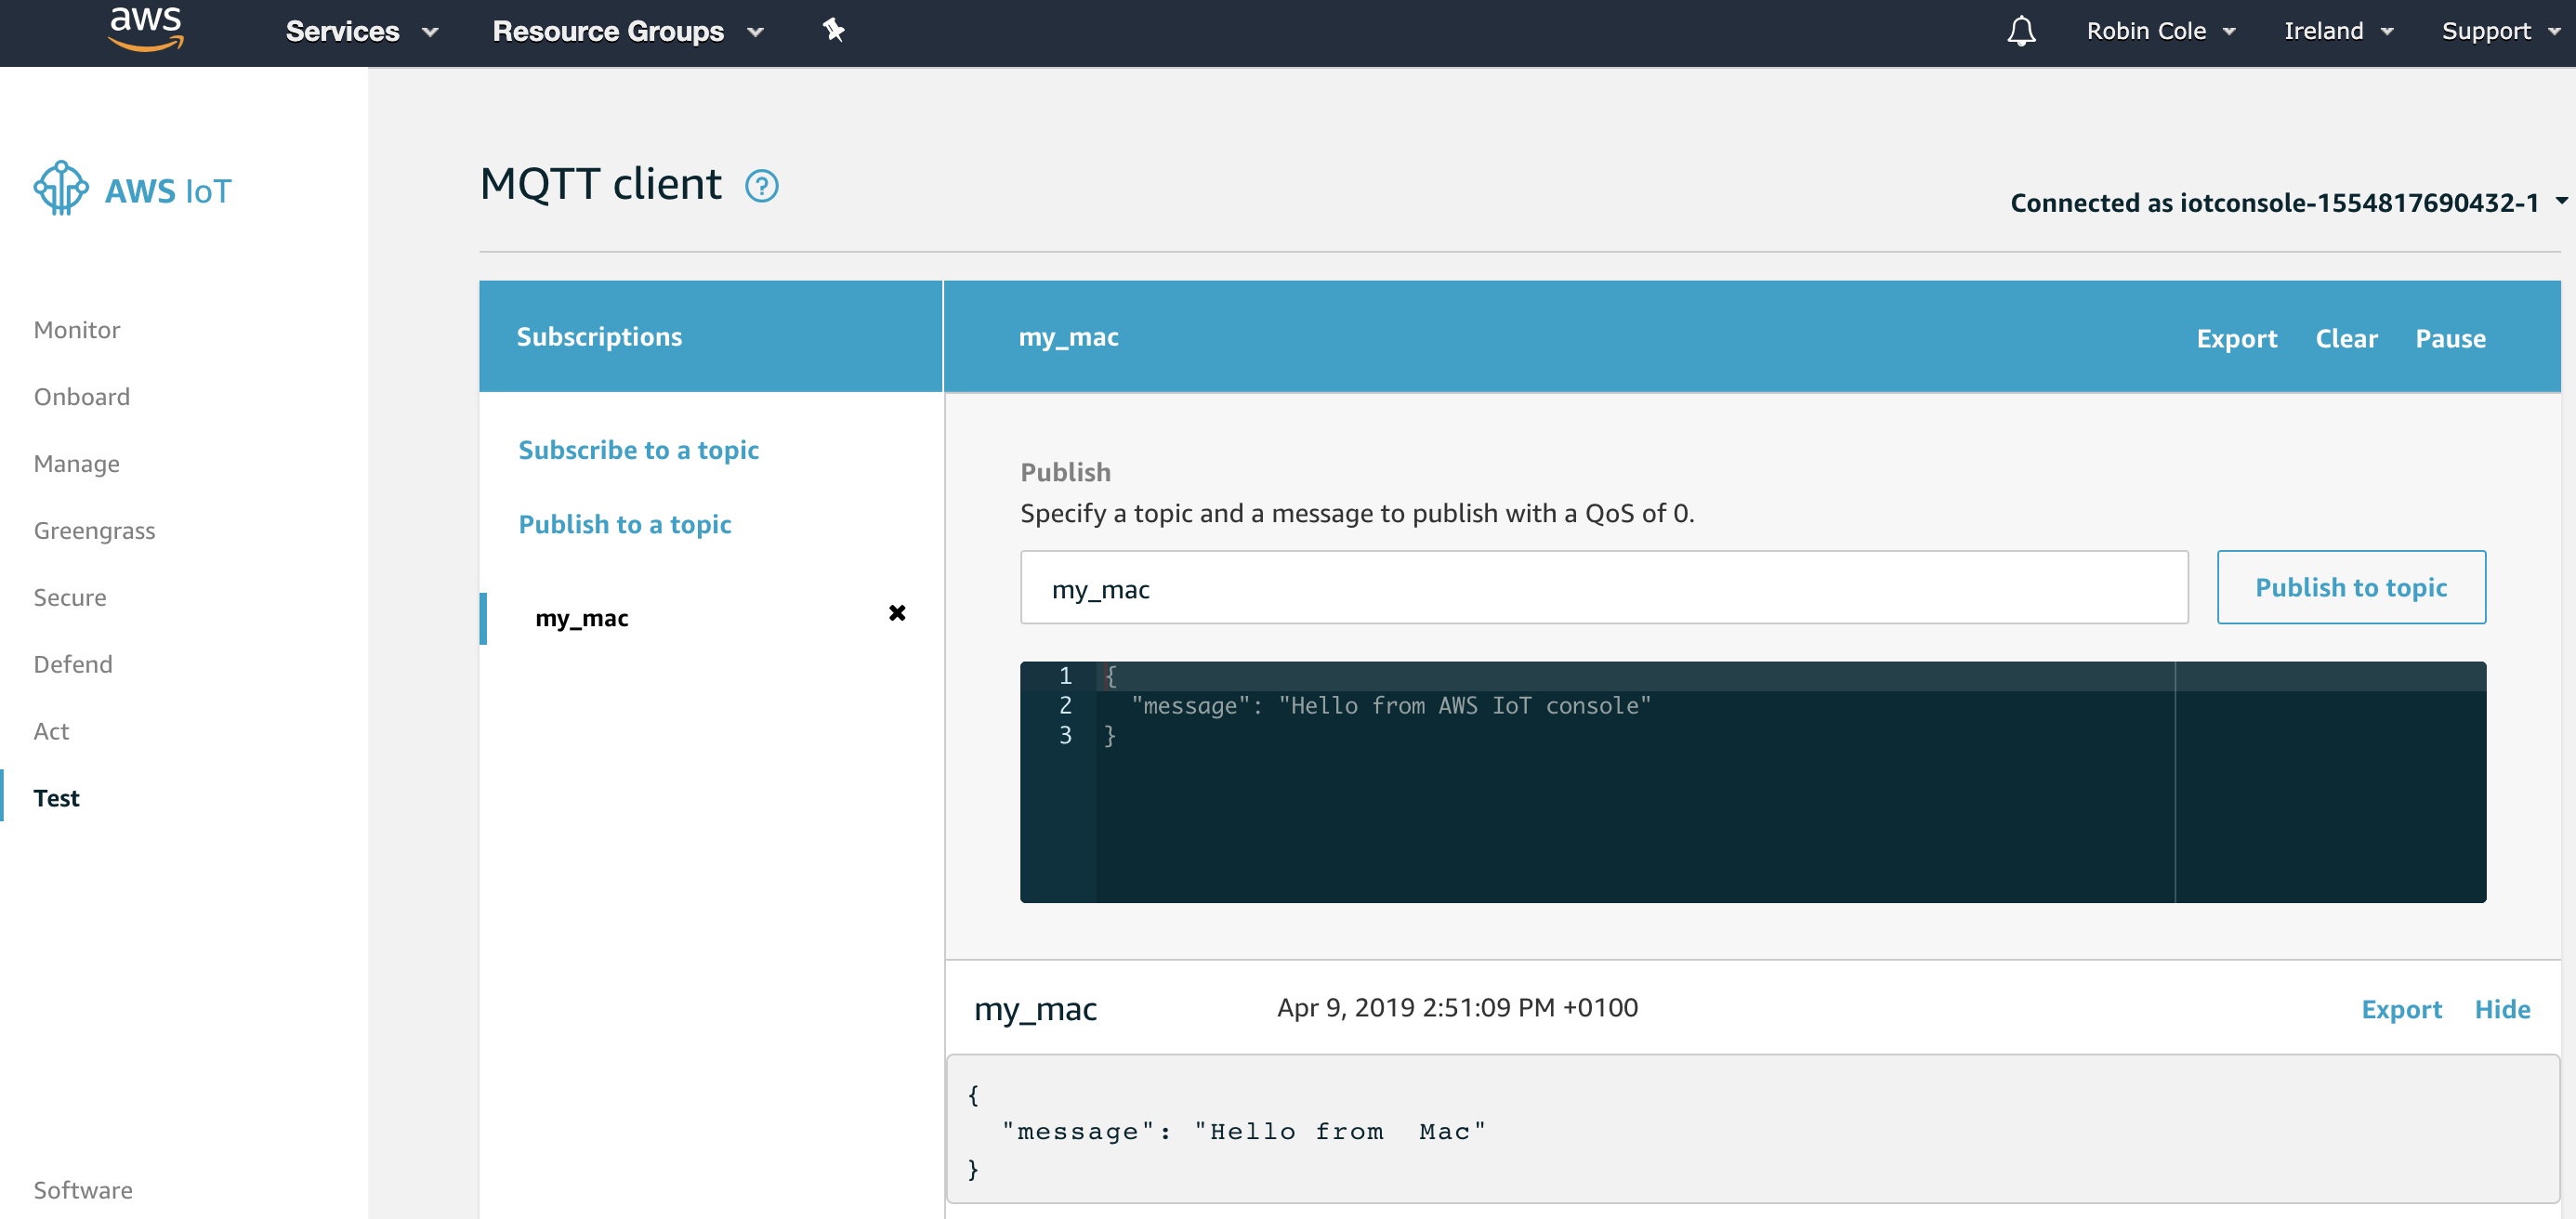

In [17]:
from IPython.display import Image
Image("resources/test_page.png")

Lets wrap this in a convenience class (put in `aws-mqtt.py`)

In [25]:
class aws_mqtt():
    def __init__(self, client_id : str = ""):
        self.myMQTTClient = AWSIoTMQTTClient(client_id)
        self.myMQTTClient.configureEndpoint(MQTT_HOST, 8883)
        self.myMQTTClient.configureCredentials(CA_ROOT_CERT_FILE, 
                                               THING_PRIVATE_KEY, 
                                               THING_CERT_FILE)
        self.myMQTTClient.configureOfflinePublishQueueing(-1)  # Infinite offline Publish queueing
        self.myMQTTClient.configureDrainingFrequency(2)  # Draining: 2 Hz
        self.myMQTTClient.configureConnectDisconnectTimeout(10)  # 10 sec
        self.myMQTTClient.configureMQTTOperationTimeout(5)  # 5 sec
        if self.myMQTTClient.connect():
            print("Connected to AWS MQTT broker")
        else:
            print("Connection to AWS MQTT broker failed")
    
    def publish(self, topic : str, message : str):
        if self.myMQTTClient.publish(topic, message, QoS=0):
            print(f"Published message : {message} | topic : {topic}")
        else:
            print(f"Failed to publish message : {message}")

In [26]:
aws_broker = aws_mqtt()

Connected to AWS MQTT broker


In [27]:
aws_broker.publish(topic=THING_NAME, message="0")

Published message : 0 | topic : robins-lidar


## Using regular paho library
* https://github.com/mariocannistra/python-paho-mqtt-for-aws-iot/blob/master/awsiotpub.py
* https://gist.github.com/skirdey/9cdead881799a47742ff3cd296d06cc1

In [25]:
import paho.mqtt.client as mqtt
import ssl
import time

# Define Variables
MQTT_PORT = 8883
MQTT_KEEPALIVE_INTERVAL = 45

In [26]:
# Define on_publish event function
def on_publish(client, userdata, mid):
    print("Message Published...")


# Initiate MQTT Client
mqttc = mqtt.Client()

# Register publish callback function
mqttc.on_publish = on_publish

# Configure TLS Set
mqttc.tls_set(CA_ROOT_CERT_FILE, certfile=THING_CERT_FILE, keyfile=THING_PRIVATE_KEY, cert_reqs=ssl.CERT_REQUIRED, tls_version=ssl.PROTOCOL_TLSv1_2, ciphers=None)

In [28]:
# Connect with MQTT Broker
mqttc.connect(MQTT_HOST, MQTT_PORT, MQTT_KEEPALIVE_INTERVAL)
mqttc.loop_start()

counter = 0
while True:
    mqttc.publish(MQTT_TOPIC, "Counter : " + str(counter),qos=1)
    counter += 1
    time.sleep(1)

Message Published...
Message Published...
Message Published...
Message Published...
Message Published...


KeyboardInterrupt: 

In [ ]:
# Disconnect from MQTT_Broker
mqttc.disconnect()